In [1]:
import numpy as np
from PIL import Image
from IPython.display import display
from lib.utils import *
from lib.utils_morphology import *

In [2]:
def show_img(img):
    return Image.fromarray(np.uint8(img*255))

In [30]:
img = Image.open('test.png')
final_result = get_roi(np.array(img))

In [18]:
type(final_result[0,0])

numpy.ndarray

In [4]:
img_new = Image.fromarray(final_result).convert("L")
test = np.array(img_new)

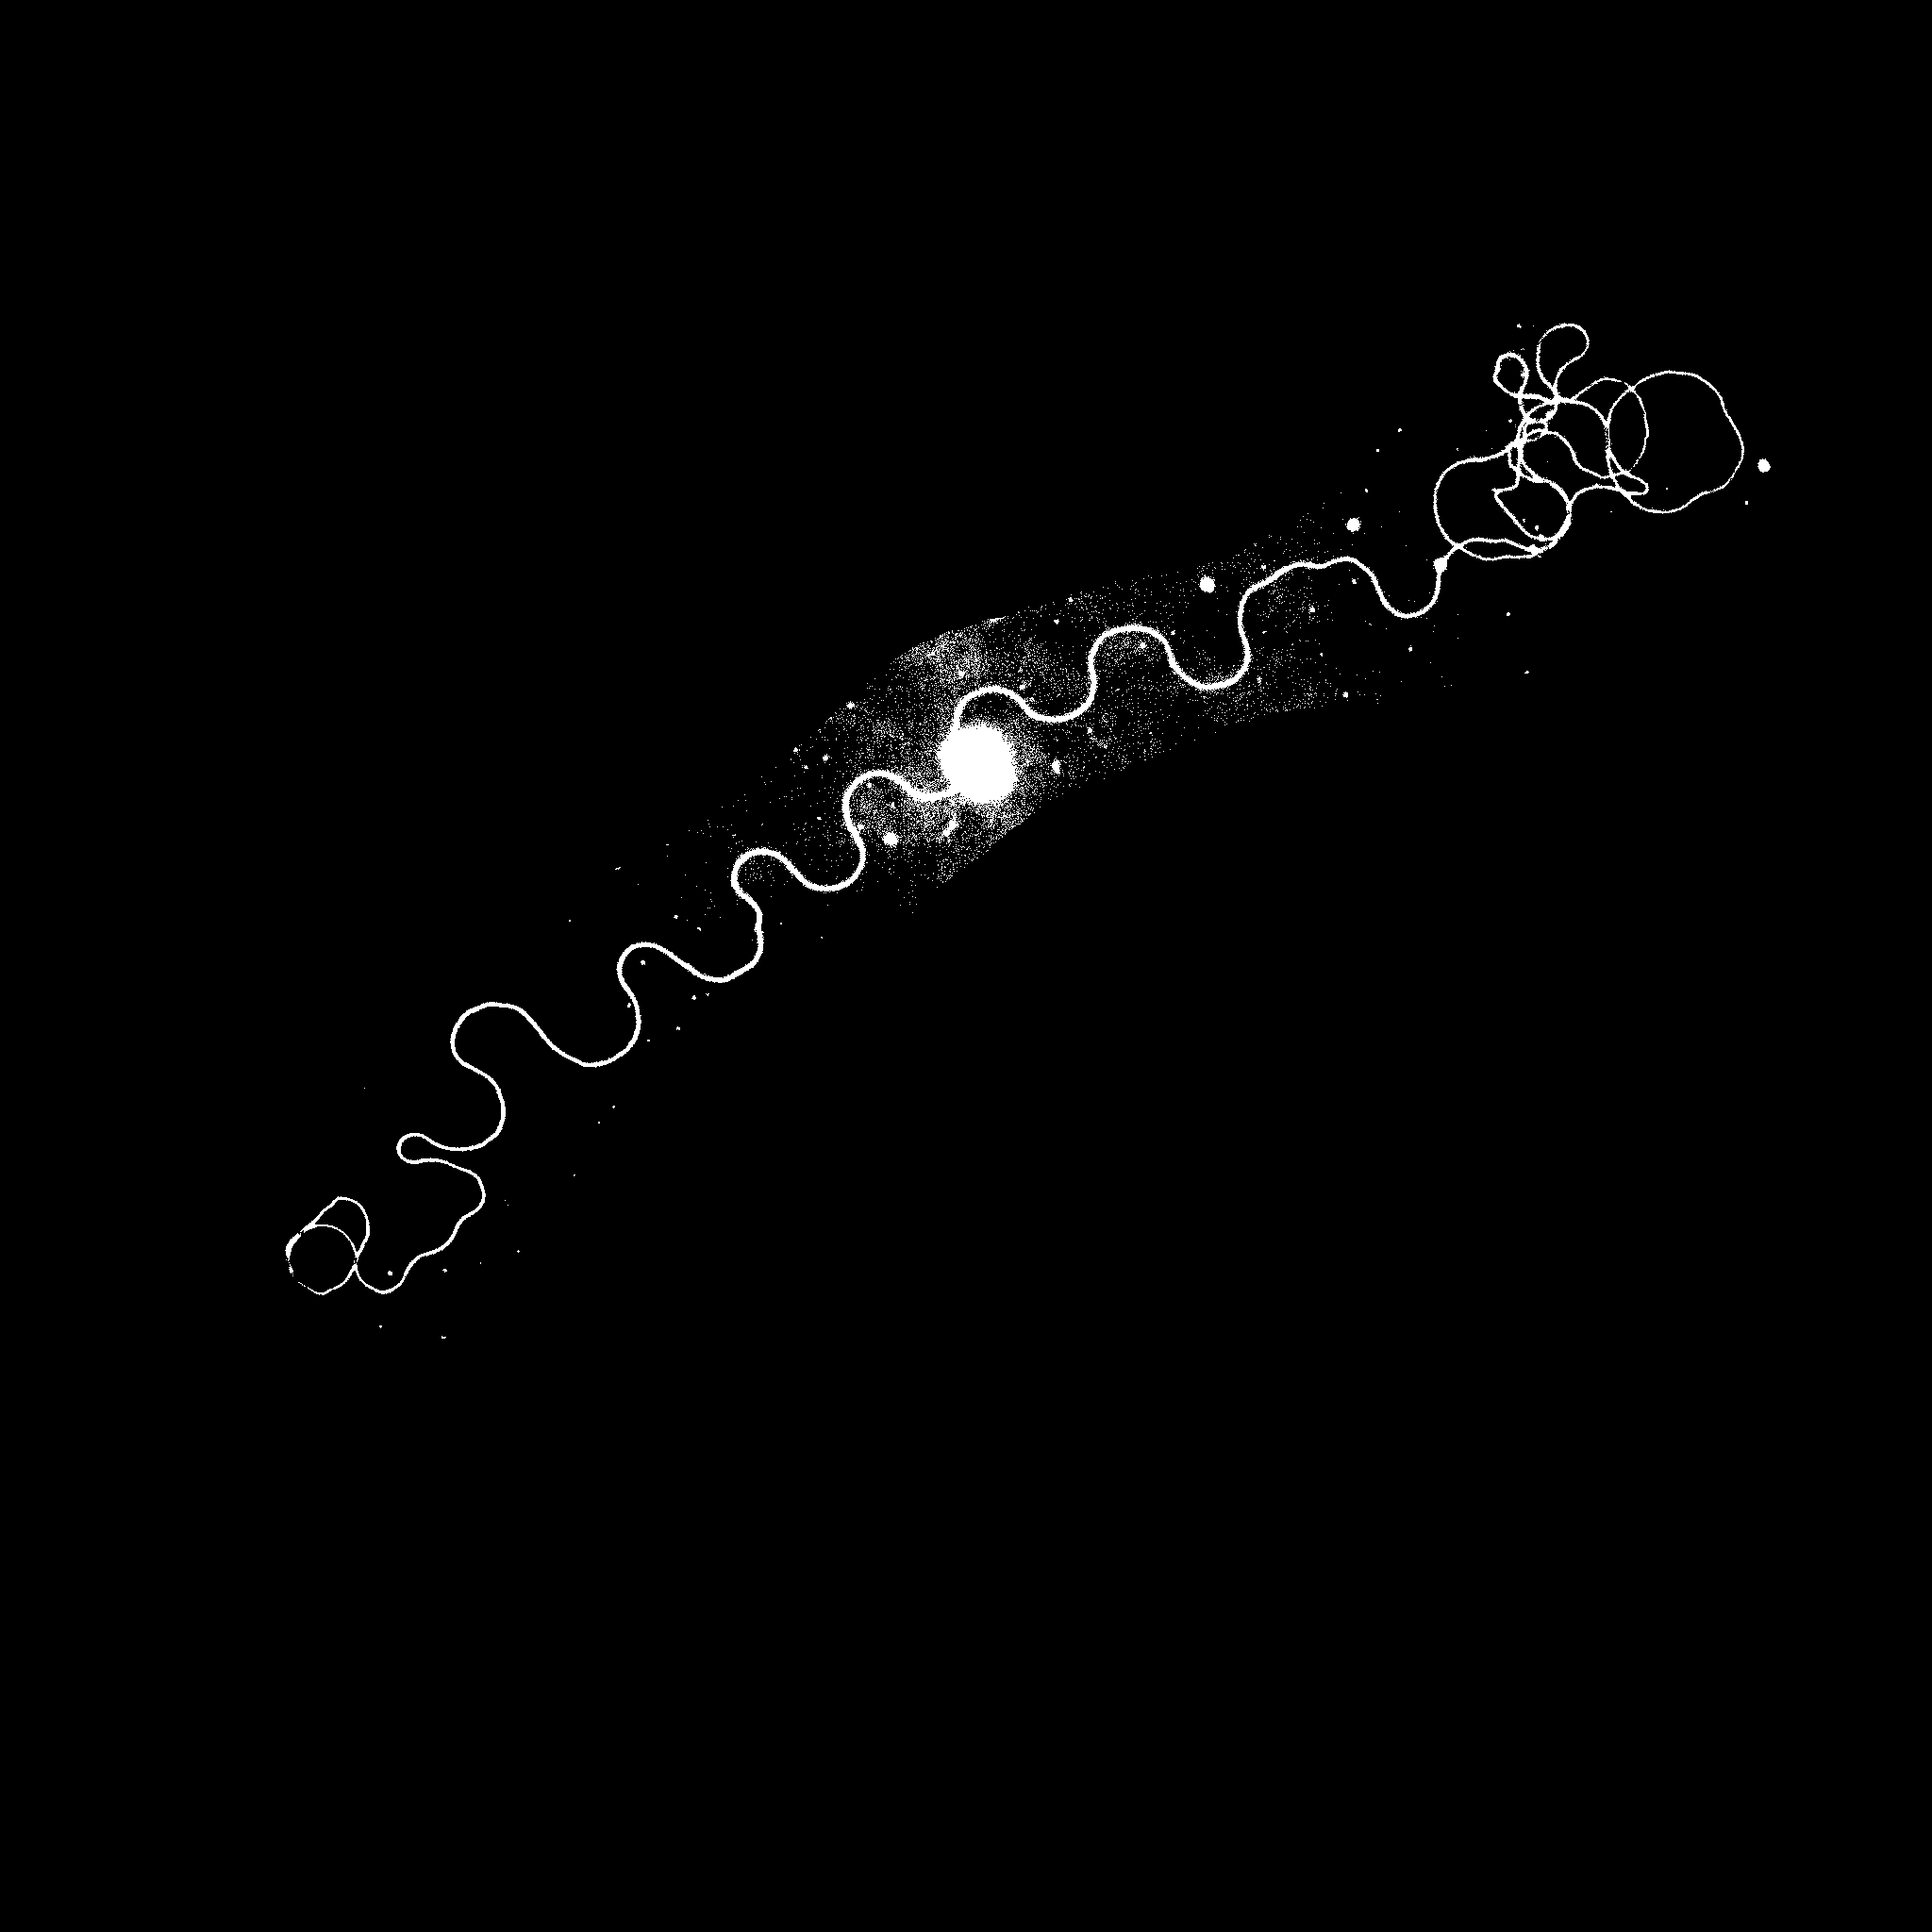

In [5]:
threshold_img = threshold(test, 165)
show_img(threshold_img)

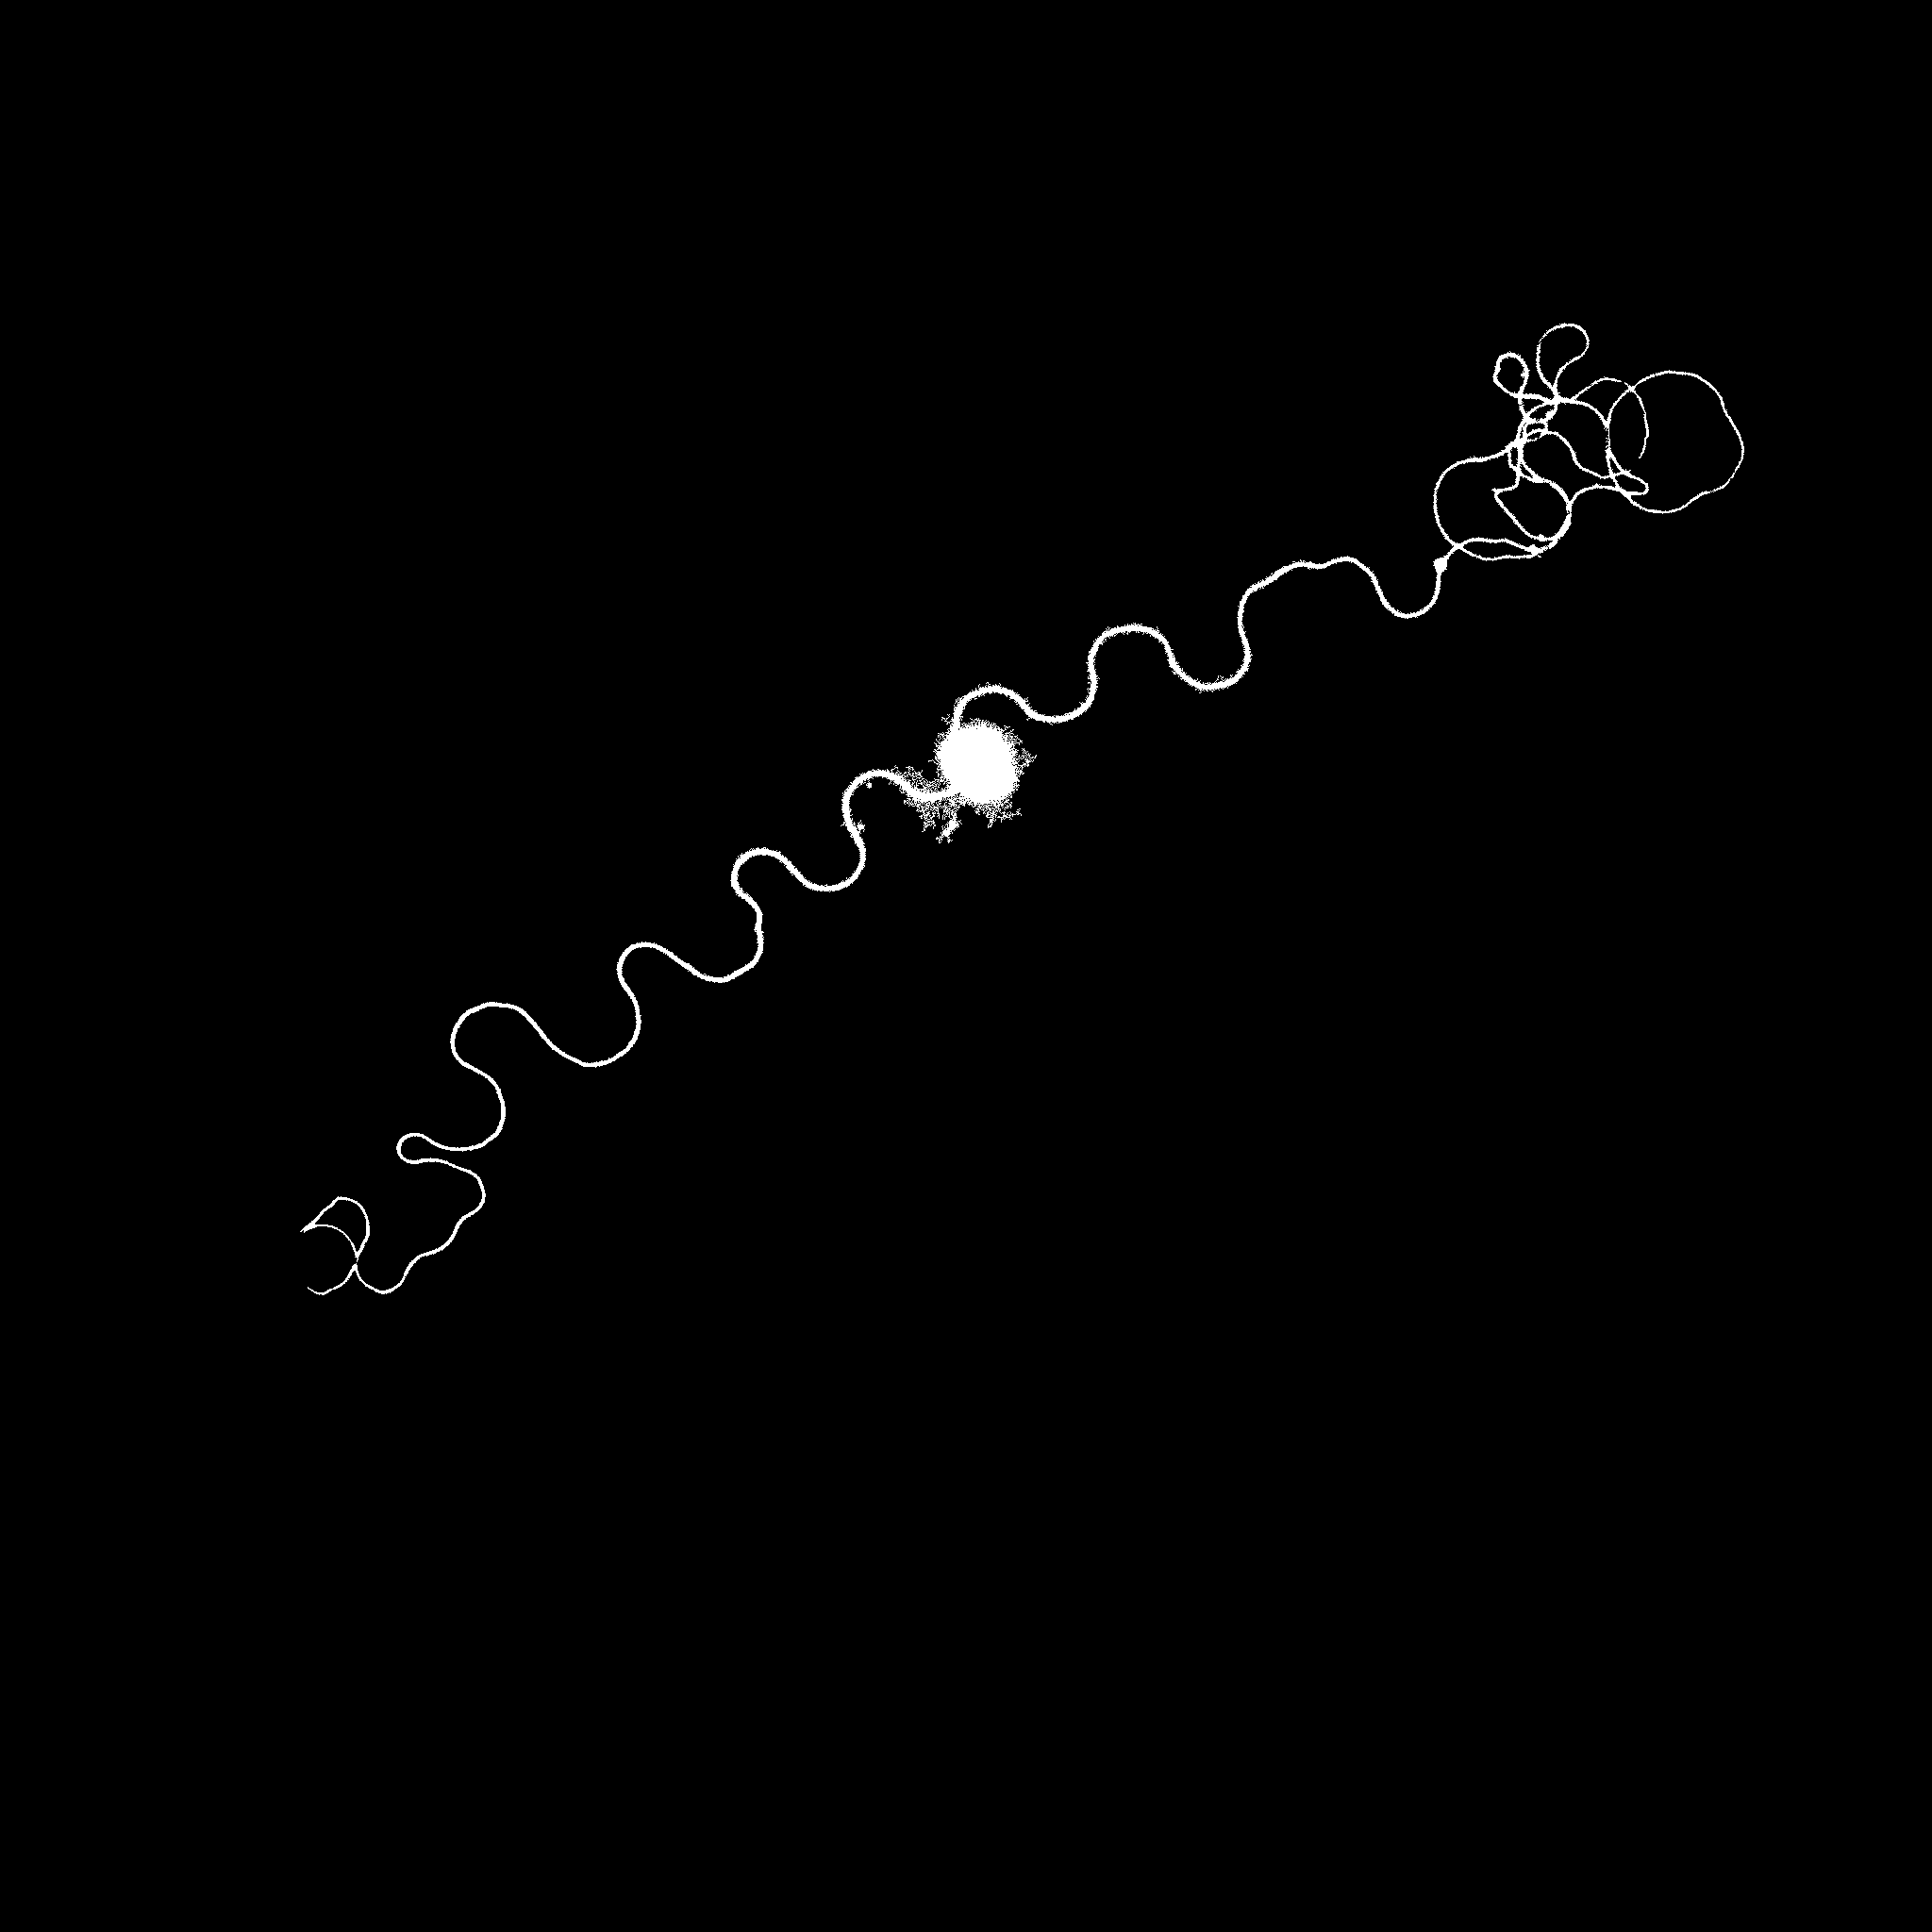

In [6]:
res = getKLargestComponents(threshold_img, 2, 0)
show_img(res)

In [7]:
res2 = close_img(res, 1)

In [8]:
def buildCC2D(array):
    zeroPos = np.array([[1, 1], [1, -1], [-1, -1], [-1, 1]])
    onePos = np.array([[1, 0], [0, -1], [-1, 0], [0, 1]])
    
    rows, cols = array.shape
    indexArray = np.zeros((2*rows + 1, 2*cols + 1), dtype=int)
    
    zeroIdx, oneIdx, twoIdx = 0, 0, 0
    res0, res1, res2 = [], [], []

    for i in range(rows):
        for j in range(cols):
            if array[i, j] == 1:
                temp2 = []
                x, y = 2*i, 2*j
                twoIdx += 1
                indexArray[x, y] = twoIdx
                
                # Check and insert one cells
                for l in range(len(onePos)):
                    m, n = [x, y] + onePos[l]
                    if indexArray[m, n] == 0:
                        oneIdx += 1
                        indexArray[m, n] = oneIdx
                    temp2.append(indexArray[m, n])
                res2.append(temp2)

                # Check and insert zero cells
                for l in range(len(zeroPos)):
                    m, n = [x, y] + zeroPos[l]
                    if indexArray[m, n] == 0:
                        zeroIdx += 1
                        indexArray[m, n] = zeroIdx
                        res0.append([(n - 1) / 2, (m - 1) / 2])

                # For one-cells, iterate through each pair of zero cells
                for k in range(len(zeroPos)):
                    x1, y1 = indexArray[x + zeroPos[k, 0], y + zeroPos[k, 1]], indexArray[x + zeroPos[(k + 1) % len(zeroPos), 0], y + zeroPos[(k + 1) % len(zeroPos), 1]]
                    if [x1, y1] not in res1 and [y1, x1] not in res1:
                        res1.append([x1, y1])

    return [res0, res1, res2]


In [9]:
cc = buildCC2D(res2)
print(len(cc[0]), len(cc[1]), len(cc[2]))

40136 72606 32425


In [10]:
def thin(cc, thresholds):
    depth = len(cc)
    
    removed = [np.zeros(len(cc[d]), dtype=int) for d in range(depth)]
    parentTable = [np.zeros(len(cc[d]), dtype=int) for d in range(depth)]

    # Populate parent table
    for d in range(1, depth):
        for r in range(len(cc[d])):
            for c in range(len(cc[d][r])):
                parentTable[d - 1][cc[d][r][c]- 1] += 1

    # Create isolation table
    isolated = [np.where(pt == 0, 0, None) for pt in parentTable]

    k = 1
    while True:
        simplePairs = []
        for d in range(1, depth):
            for r in range(len(cc[d])):
                if removed[d][r] != 1:
                    candidates = [c for c in cc[d][r] if parentTable[d - 1][c - 1] == 1]
                    if candidates:
                        t = candidates[0] - 1
                        cell1 = (d - 1, t)
                        cell2 = (d, r)
                        ix = isolated[cell2[0]][cell2[1]]
                        if cell2[0] != 1:
                            if not ((k - ix > thresholds[0][0]) and (1 - ix/k > thresholds[0][1])):
                                simplePairs.append((cell1, cell2))
                        else:
                            simplePairs.append((cell1, cell2))

        if not simplePairs:
            break

        for cell1, cell2 in simplePairs:
            for m in cc[cell2[0]][cell2[1]]:
                tx, ty = cell2[0] - 1, m - 1
                parentTable[tx][ty] -= 1
                if parentTable[tx][ty] == 0:
                    isolated[tx][ty] = k

            if cell1[0] > 0:
                for m in cc[cell1[0]][cell1[1]]:
                    tx, ty = cell1[0] - 1, m - 1
                    parentTable[tx][ty] -= 1
                    if parentTable[tx][ty] == 0:
                        isolated[tx][ty] = k
                        
    
            # print(cell1, cell2)            
            
            removed[cell1[0]][cell1[1] - 1] = 1
            removed[cell2[0]][cell2[1] - 1] = 1

        k += 1

    resCC = []
    for d in range(depth):
        temp = []
        rTemp = 0
        for r in range(len(cc[d])):
            if removed[d][r] != 1:
                temp.append(cc[d][r])
                rTemp += 1
            elif d != depth - 1:
                for sublist in cc[d + 1]:
                    for i in range(len(sublist)):
                        if sublist[i] > rTemp:
                            sublist[i] -= 1
        resCC.append(temp)

    return resCC


In [11]:
thined = thin(cc, [[5, 0.5]])

In [12]:
len(thined[0]), len(thined[1]), len(thined[2])

(23221, 35318, 11769)

In [13]:
thined[0]

[[1658.0, 342.0],
 [1658.0, 341.0],
 [1653.0, 342.0],
 [1655.0, 343.0],
 [1654.0, 342.0],
 [1655.0, 342.0],
 [1658.0, 343.0],
 [1660.0, 342.0],
 [1662.0, 343.0],
 [1661.0, 342.0],
 [1662.0, 342.0],
 [1663.0, 342.0],
 [1664.0, 342.0],
 [1665.0, 342.0],
 [1666.0, 342.0],
 [1652.0, 344.0],
 [1653.0, 344.0],
 [1654.0, 344.0],
 [1655.0, 344.0],
 [1656.0, 344.0],
 [1657.0, 344.0],
 [1658.0, 344.0],
 [1659.0, 344.0],
 [1660.0, 344.0],
 [1663.0, 344.0],
 [1664.0, 344.0],
 [1665.0, 344.0],
 [1666.0, 344.0],
 [1667.0, 344.0],
 [1668.0, 344.0],
 [1671.0, 343.0],
 [1649.0, 345.0],
 [1648.0, 344.0],
 [1649.0, 344.0],
 [1650.0, 344.0],
 [1652.0, 345.0],
 [1654.0, 345.0],
 [1655.0, 345.0],
 [1656.0, 345.0],
 [1657.0, 345.0],
 [1667.0, 345.0],
 [1668.0, 345.0],
 [1669.0, 345.0],
 [1670.0, 345.0],
 [1674.0, 344.0],
 [1647.0, 346.0],
 [1648.0, 346.0],
 [1649.0, 346.0],
 [1650.0, 346.0],
 [1654.0, 346.0],
 [1655.0, 346.0],
 [1664.0, 346.0],
 [1671.0, 346.0],
 [1672.0, 346.0],
 [1673.0, 346.0],
 [1675.0, 

In [31]:
for i in cc[0]:
    final_result[int(i[1]), int(i[0])]=np.array([255, 0, 0])

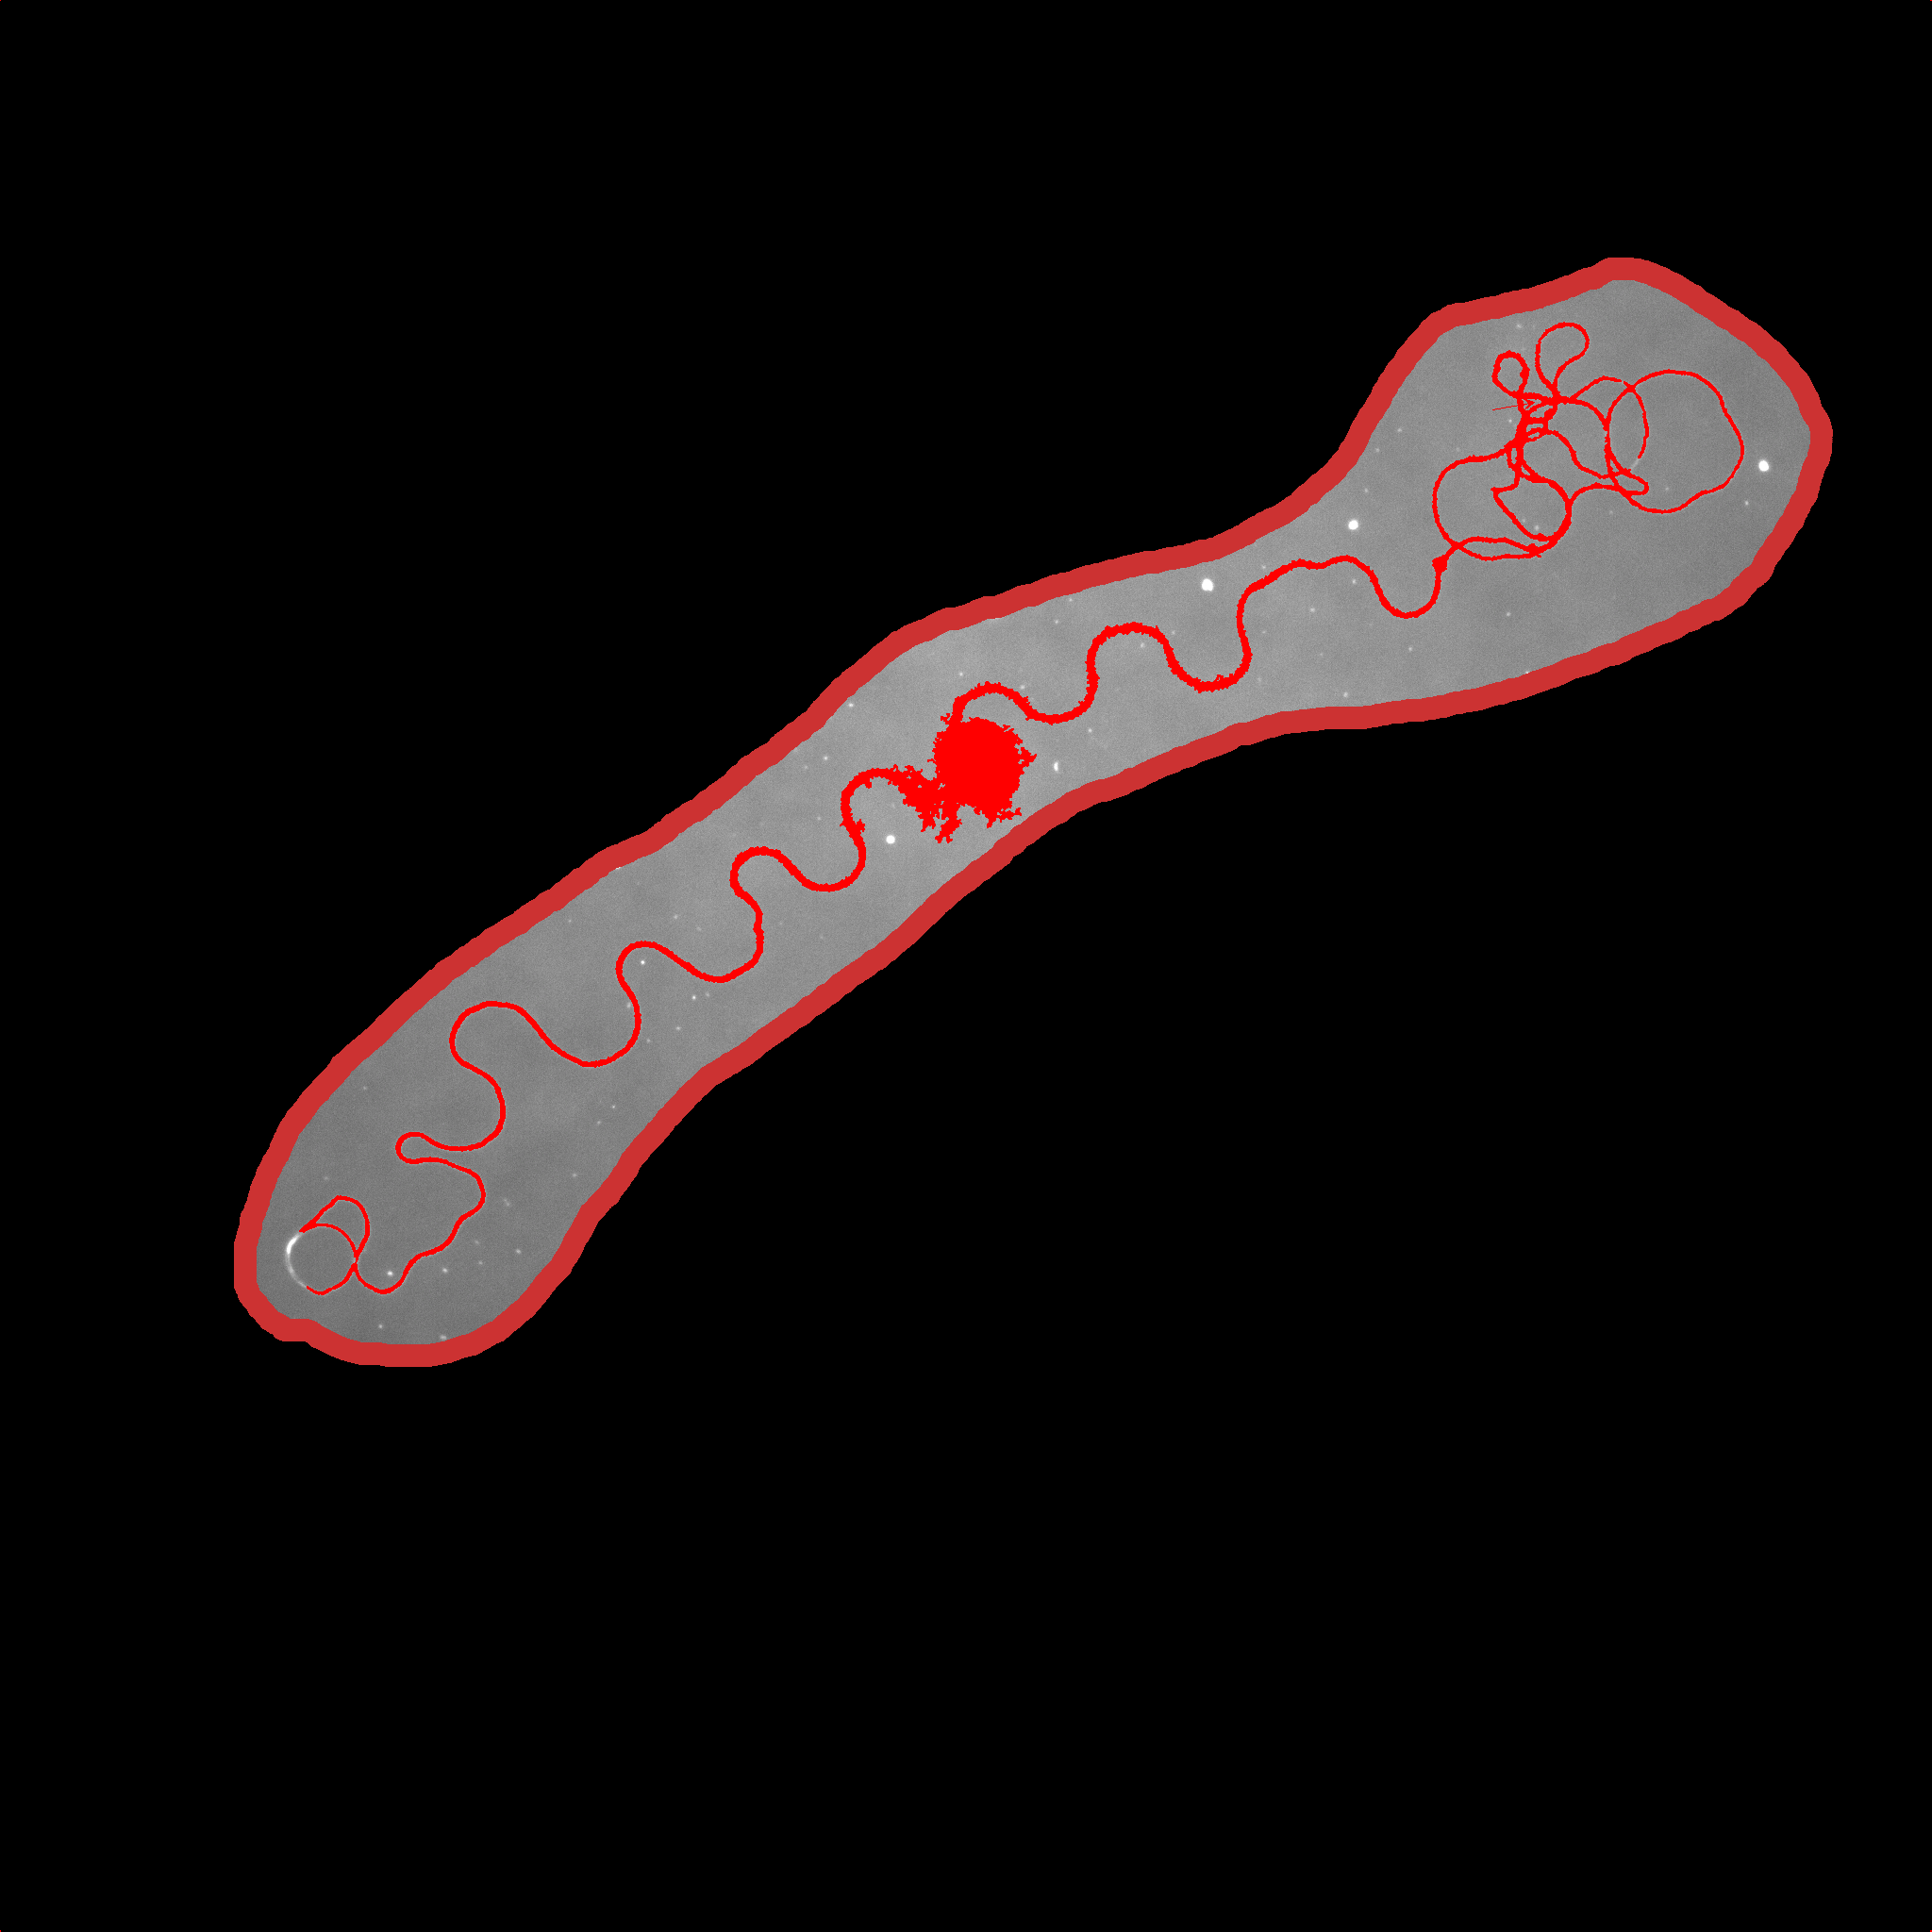

In [32]:
Image.fromarray(np.uint8(final_result))